In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

Data Loader

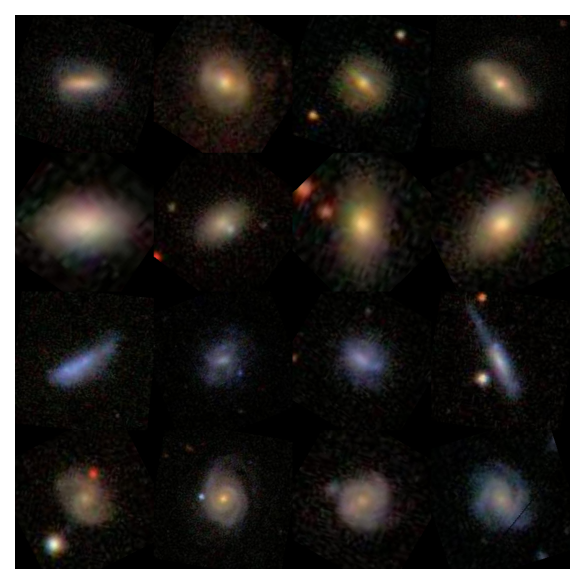

[['barred' 'barred' 'barred' 'barred']
 ['elliptical' 'elliptical' 'elliptical' 'elliptical']
 ['irregular' 'irregular' 'irregular' 'irregular']
 ['spiral' 'spiral' 'spiral' 'spiral']]
torch.Size([16, 3, 224, 224])


In [16]:
import numpy as np

transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=180),# this is a data augmentation technique that randomly rotates the images by up to 180 degrees
    torchvision.transforms.RandomHorizontalFlip(), # this is a data augmentation technique that randomly flips the images horizontally
    torchvision.transforms.ToTensor() # this converts the images to PyTorch tensors
])
path = r'E:\machine learning\class exercises\final machine learning project - galaxies\250711-galaxies-data\galaxies\train'
train_set = torchvision.datasets.ImageFolder(path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=2)
testpath = r"E:\machine learning\class exercises\final machine learning project - galaxies\250711-galaxies-data\galaxies\test"
test_set = torchvision.datasets.ImageFolder(testpath, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, drop_last=False, num_workers=2)


images_per_class = []
labels_list = []

for class_idx in range(len(train_set.classes)):
    count = 0
    for img, label in train_set:
        if label == class_idx:
            images_per_class.append(img)
            labels_list.append(train_set.classes[label])
            count += 1
        if count == 4:
            break

# Stack and make grid (no padding)
images_tensor = torch.stack(images_per_class)
grid = torchvision.utils.make_grid(images_tensor, nrow=4, padding=0, normalize=True).permute(1, 2, 0)

# Plot
plt.figure(dpi=150)
plt.axis("off")
plt.imshow(grid)
plt.show()

# Print label matrix
label_matrix = np.array(labels_list).reshape(4, 4)
print(label_matrix)
print(images_tensor.shape)

Features Extraction

In [3]:
def color_histogram(img, bins=64):
    n = img.shape[0]
    img = (img * bins).long().clamp(0, bins - 1)
    img = img + torch.arange(0, 3 * n * bins, bins, device=img.device).view(n, 3, 1, 1)
    hist = torch.bincount(img.view(-1), minlength=(3 * n * bins)).view(n, 3 * bins)
    return hist / img[0].numel()


def edge_direction_histogram(img, bins=64):
    n = img.shape[0]
    SOBEL = torch.tensor([
        [[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]],
        [[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]
    ], dtype=img.dtype, device=img.device)
    gray = img.mean(1, True)
    grad = torch.nn.functional.conv2d(gray, SOBEL)
    magnitude = grad.norm(dim=1)
    angle = torch.atan2(grad[:, 0], grad[:, 1])
    directions = (bins * angle / (2 * torch.pi)).long() % bins
    directions = directions + torch.arange(0, n * bins, bins, device=img.device).view(n, 1, 1)
    hist = torch.bincount(directions.view(-1), weights=magnitude.view(-1), minlength=n * bins).view(n, bins)
    hist = hist / hist.sum(1, True).clamp(1e-6)
    return hist


def _cooccurrence_matrix_dir(values, bins, di, dj):
    b, m, n = values.shape
    codes = values[:, :m - di, :n - dj] + bins * values[:, di:, dj:]
    codes += torch.arange(0, b * (bins ** 2), bins ** 2, device=values.device).view(b, 1, 1)
    entries = torch.bincount(codes.view(-1), minlength=b * (bins ** 2)).view(b, bins, bins)
    return entries


def rgb_cooccurrence_matrix(img, quantization=3, distance=10):
    n = img.shape[0]
    img = (img * quantization).long().clamp(0, quantization - 1)
    img = (img * (torch.arange(3, device=img.device) ** quantization).view(1, 3, 1, 1)).sum(1)
    bins = quantization ** 3
    mat = _cooccurrence_matrix_dir(img, bins, distance, 0)
    mat += _cooccurrence_matrix_dir(img, bins, 0, distance)
    mat = (mat + mat.permute(0, 2, 1)).view(n, -1)
    mat = mat / mat.sum(1, True)
    return mat


x = torch.rand(7, 3, 200, 200)
h = rgb_cooccurrence_matrix(x)
print(h.shape)

torch.Size([7, 729])


LR1 model with one feature

In [4]:
LR = 0.01
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

model_LR1 = torch.nn.Linear(192, len(train_set.classes))
model_LR1.to(DEVICE)
optimizer_LR1 = torch.optim.Adam(model_LR1.parameters(), lr=LR)
loss_fun = torch.nn.CrossEntropyLoss()

Using device: cuda


Training Loop LR1

In [5]:
EPOCHS = 20
def extract_features_LR1(img_batch):
    return color_histogram(img_batch)

train_losses = []
train_accuracies = []
def train_epoch(model, optimizer, EPOCHS, train_loader, DEVICE, extract_features):
  
  for epoch in range(EPOCHS):
    model_LR1.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        feats = extract_features(images)           # [B, 192]
        output = model(feats)                      # [B, num_classes]
        loss = loss_fun(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = output.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    avg_loss = total_loss / total

    train_losses.append(avg_loss)
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {acc:.2f}%")
    
train_epoch(model_LR1, optimizer_LR1, EPOCHS, train_loader, DEVICE, extract_features_LR1)


Epoch 1: Loss = 1.3381, Accuracy = 39.79%
Epoch 2: Loss = 1.2757, Accuracy = 47.49%
Epoch 3: Loss = 1.2429, Accuracy = 50.52%
Epoch 4: Loss = 1.2197, Accuracy = 52.29%
Epoch 5: Loss = 1.2029, Accuracy = 53.74%
Epoch 6: Loss = 1.1867, Accuracy = 54.69%
Epoch 7: Loss = 1.1736, Accuracy = 55.78%
Epoch 8: Loss = 1.1607, Accuracy = 56.63%
Epoch 9: Loss = 1.1476, Accuracy = 57.17%
Epoch 10: Loss = 1.1388, Accuracy = 57.66%
Epoch 11: Loss = 1.1283, Accuracy = 58.45%
Epoch 12: Loss = 1.1195, Accuracy = 58.39%
Epoch 13: Loss = 1.1105, Accuracy = 58.95%
Epoch 14: Loss = 1.1039, Accuracy = 59.31%
Epoch 15: Loss = 1.0958, Accuracy = 60.06%
Epoch 16: Loss = 1.0873, Accuracy = 59.97%
Epoch 17: Loss = 1.0812, Accuracy = 60.58%
Epoch 18: Loss = 1.0750, Accuracy = 60.43%
Epoch 19: Loss = 1.0691, Accuracy = 60.86%
Epoch 20: Loss = 1.0629, Accuracy = 61.50%


Evaluation Loop LR1

[Model LR1 Accuracy] 65.50%


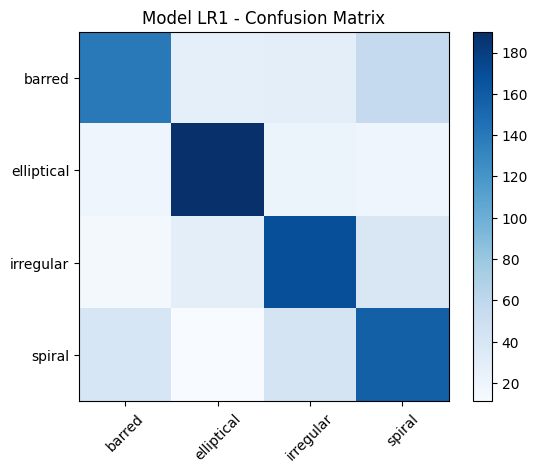

In [6]:


def evaluate_classifier(model, extract_features, test_loader, name):
    model.eval()
    nclasses = len(train_set.classes)
    cm = torch.zeros(nclasses, nclasses, dtype=torch.long)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            feats = extract_features(images)
            outputs = model(feats)
            preds = outputs.argmax(1)
            for t, p in zip(labels.view(-1), preds.view(-1)):
                cm[t.long(), p.long()] += 1

    accuracy = cm.diag().sum().item() / cm.sum().item()
    print(f"[{name} Accuracy] {accuracy * 100:.2f}%")

    plt.figure(dpi=100)
    plt.imshow(cm, cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xticks(range(nclasses), train_set.classes, rotation=45)
    plt.yticks(range(nclasses), train_set.classes)
    plt.colorbar()
    plt.show()

evaluate_classifier(model_LR1, extract_features_LR1, test_loader, name="Model LR1")


Performance Graphs LR1

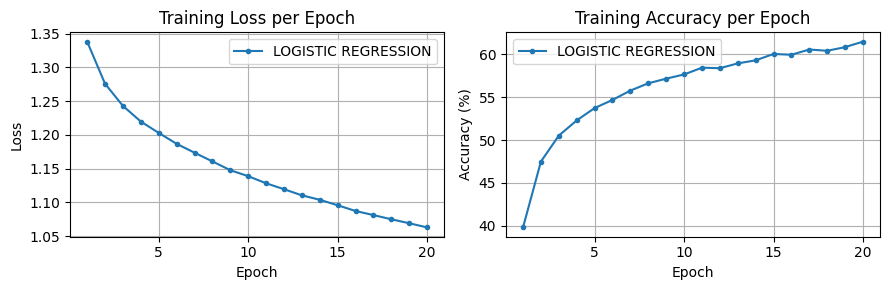

In [7]:

def plot_metrics(losses, accs, title):
    epochs = range(1, len(losses)+1)

    plt.figure(figsize=(9, 3))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label=title, marker='.')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss per Epoch")
    plt.grid(True)
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accs, label=title, marker='.')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, train_accuracies, "LOGISTIC REGRESSION")

Traning Loop with 3 features - LR3

In [8]:
model_LR3 = torch.nn.Linear(985, len(train_set.classes))
model_LR3.to(DEVICE)
optimizer_LR3 = torch.optim.Adam(model_LR3.parameters(), lr=LR)
loss_fun = torch.nn.CrossEntropyLoss()
def extract_features_LR3(img_batch):
    f1 = color_histogram(img_batch)
    f2 = edge_direction_histogram(img_batch)
    f3 = rgb_cooccurrence_matrix(img_batch)
    return torch.cat([f1, f2, f3], dim=1)  # shape: [B, 985]
del train_losses, train_accuracies
train_losses = []
train_accuracies = []
train_epoch(model_LR3, optimizer_LR3, EPOCHS, train_loader, DEVICE, extract_features_LR3)


Epoch 1: Loss = 1.3073, Accuracy = 45.32%
Epoch 2: Loss = 1.2050, Accuracy = 54.81%
Epoch 3: Loss = 1.1486, Accuracy = 58.31%
Epoch 4: Loss = 1.1116, Accuracy = 59.66%
Epoch 5: Loss = 1.0822, Accuracy = 60.25%
Epoch 6: Loss = 1.0590, Accuracy = 61.85%
Epoch 7: Loss = 1.0413, Accuracy = 62.51%
Epoch 8: Loss = 1.0262, Accuracy = 63.03%
Epoch 9: Loss = 1.0131, Accuracy = 63.40%
Epoch 10: Loss = 0.9998, Accuracy = 64.49%
Epoch 11: Loss = 0.9890, Accuracy = 65.12%
Epoch 12: Loss = 0.9784, Accuracy = 65.05%
Epoch 13: Loss = 0.9700, Accuracy = 65.20%
Epoch 14: Loss = 0.9621, Accuracy = 65.66%
Epoch 15: Loss = 0.9548, Accuracy = 66.07%
Epoch 16: Loss = 0.9478, Accuracy = 66.19%
Epoch 17: Loss = 0.9393, Accuracy = 66.68%
Epoch 18: Loss = 0.9350, Accuracy = 67.19%
Epoch 19: Loss = 0.9275, Accuracy = 67.21%
Epoch 20: Loss = 0.9231, Accuracy = 67.46%


Evaluation  with confusion matrix - LR3

[Model LR3 Accuracy] 68.50%


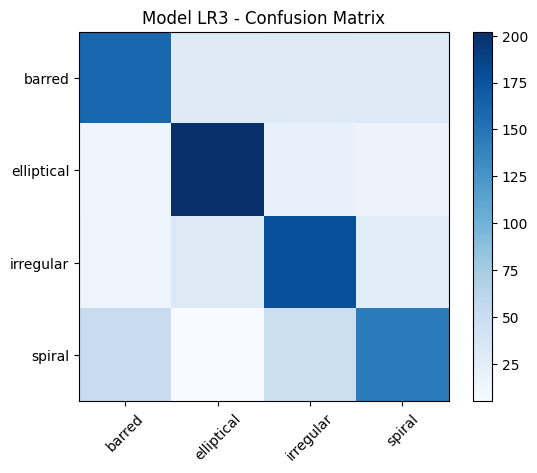

In [9]:
evaluate_classifier(model_LR3, extract_features_LR3, test_loader, name="Model LR3")


Performance Graphs for LR3

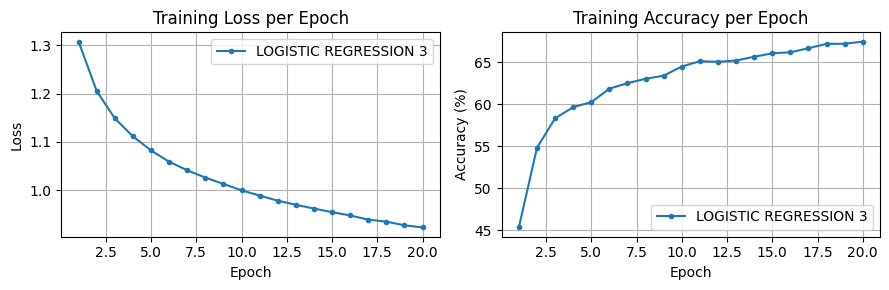

In [10]:

plot_metrics(train_losses, train_accuracies, "LOGISTIC REGRESSION 3")

SVM model with 3 features 

In [11]:
class LinearSVM(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, num_classes, bias=True)

    def forward(self, x):
        return self.linear(x)  # raw scores


Hinge Loss function for SVM

In [12]:
def multiclass_hinge_loss( outputs, labels, C=1.0):
    # outputs: [B, C], labels: [B]
    num_classes = outputs.size(1)
    correct_class_scores = outputs[torch.arange(outputs.size(0)), labels].unsqueeze(1)  # [B, 1]
    margins = torch.clamp(outputs - correct_class_scores + 1.0, min=0.0)  # [B, C]
    margins[torch.arange(outputs.size(0)), labels] = 0  # do not count correct class
    loss = margins.sum() / outputs.size(0)
    
    # Add L2 regularization (manually)
    reg_loss = 0.0
    for param in model_LR3.parameters():
        reg_loss += torch.norm(param) ** 2
    return loss + 0.0005 * reg_loss  # C is regularization strength


Training Loop SVM

In [13]:
model_SVM3  = LinearSVM(input_dim=985, num_classes=len(train_set.classes)).to(DEVICE)
optimizer = torch.optim.SGD(model_SVM3 .parameters(), lr=0.01)
epochs = 20
loader  = train_loader
svm_losses = []
svm_accuracies = []
def train_svm_model(epochs, loader, extract_features):


    for epoch in range(epochs):
        model_SVM3 .train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            feats = extract_features(images)
            outputs = model_SVM3 (feats)
            loss = multiclass_hinge_loss(outputs, labels, model_SVM3)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        avg_loss = total_loss / total
        svm_losses.append(avg_loss)
        svm_accuracies.append(acc)
        
        print(f"[SVM Epoch {epoch+1}] Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")
train_svm_model(epochs, loader, extract_features_LR3)

[SVM Epoch 1] Loss: 103.2883, Accuracy: 24.18%
[SVM Epoch 2] Loss: 103.2773, Accuracy: 25.14%
[SVM Epoch 3] Loss: 103.2665, Accuracy: 26.00%
[SVM Epoch 4] Loss: 103.2558, Accuracy: 25.33%
[SVM Epoch 5] Loss: 103.2442, Accuracy: 25.62%
[SVM Epoch 6] Loss: 103.2324, Accuracy: 26.32%
[SVM Epoch 7] Loss: 103.2217, Accuracy: 26.96%
[SVM Epoch 8] Loss: 103.2104, Accuracy: 27.25%
[SVM Epoch 9] Loss: 103.2015, Accuracy: 28.62%
[SVM Epoch 10] Loss: 103.1917, Accuracy: 25.13%
[SVM Epoch 11] Loss: 103.1818, Accuracy: 26.20%
[SVM Epoch 12] Loss: 103.1734, Accuracy: 25.82%
[SVM Epoch 13] Loss: 103.1639, Accuracy: 27.56%
[SVM Epoch 14] Loss: 103.1548, Accuracy: 25.00%
[SVM Epoch 15] Loss: 103.1452, Accuracy: 25.33%
[SVM Epoch 16] Loss: 103.1356, Accuracy: 25.34%
[SVM Epoch 17] Loss: 103.1268, Accuracy: 28.58%
[SVM Epoch 18] Loss: 103.1154, Accuracy: 25.28%
[SVM Epoch 19] Loss: 103.1067, Accuracy: 25.07%
[SVM Epoch 20] Loss: 103.0993, Accuracy: 25.03%


Evaluation with confusion matrix - SVM

[SVM3 Accuracy] 25.20%


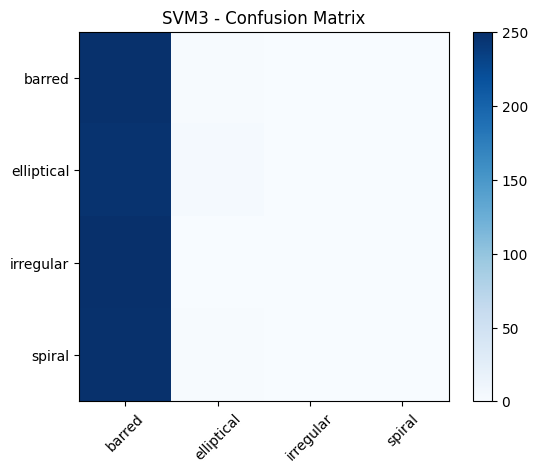

In [14]:
evaluate_classifier(model_SVM3 , extract_features_LR3, test_loader, name="SVM3")



Performance Graphs - SVM

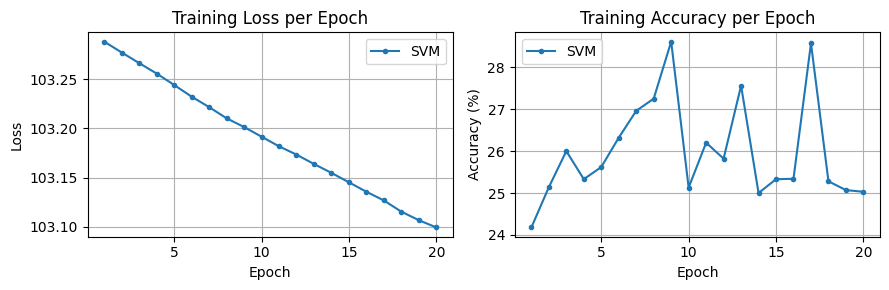

In [15]:

plot_metrics(svm_losses, svm_accuracies, "SVM")